Recurrent Neural Networks
- Better deal with sequence data
    - time series
    - sentences
    - audio
    - car trajectories
    - music
- data that comes in a specific, signficiant order

The neuron needs to know about previous history of outputs
- feed its output back in as a new input

Recurrent Nueron
- sends ouput back into itself

Memory Cells- cells that are a function of inputs from previous time steps

RNN are flexible in their inputs and outputs for sequences and single vector values

Can create entire layers of recurrent neurons

Sequence to Sequence (many to many)
- given five previous words, predict the next five words

Sequence to Vector (many to one)
- given five previous words, predict the next word

Vector to sequence (one to many)
- given one word, predict the next five

Disadvantages of RNN 
- it only remembers the one previous output
- vanishing gradient (Long Short Term Memory Units will help with this)

Exploding and Vanishing Gradients
- gradient is used to adjust weights and biases in network
- issue arise from back propigation
    - gradients get smaller and smaller until they eventually do not have an effect, causing weights to not change

To fix this
- ReLu doesn't saturate positive values
- perform batch normalization
    - model will normalize each batch using that batches mean and sd
- choosing different initialization of weights 
    - Xavier Initialization
    
Exploding Gradients 
- get larger and larger, multiplying large values moving towards infinity
- tp fix this use gradient clipping

LSTM and GRU Units

- shortening the time steps used for prediction makes the model worse at predicting longer trends
- network will "forget" first inputs 

LSTM Long short term memory cell was created to help address these RNN issues

a recurrent neuron takes previous output (hidden state) and current input to produce ouput



a LSTM has four layers that interact
(inside this is a hyperbolic tangent function)
- long term memory input 
- short term memory input
- new long term memory
- new short term memory

as well as
- input at time t
- output at time t


there are gates inside (gates optionally let information through)
- can be thought of as a sigmoid function, if its a 1 it gets through if its a 0 it doesn't
    - input gate
    - forget gate
    - update gate
    - output gate

LSTM with peepholes
- let multiple gate layers look at the cell state

Gated Recurrent Unit (GRU)
- combine forget and input into update gate
- simpler than standard LSTM

As you continue to forcast further out, you have a higher liklihood that the forecsted values will deviate since you are forecasting on forecasted values

In [1]:
import torch
import torch.nn as nn
 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
x = torch.linspace(0, 799, 800)

In [3]:
#define a sin wave off these points
y = torch.sin(x*2*3.1416/40)

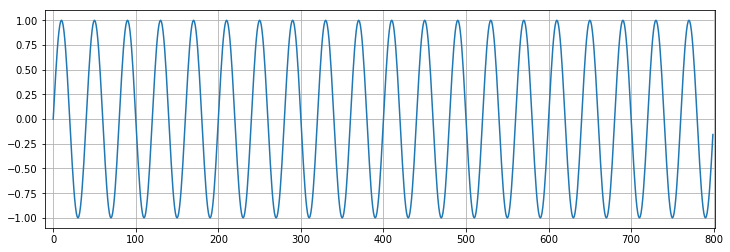

In [4]:
plt.figure(figsize= (12,4))
plt.xlim(-10, 801)
plt.grid(True)
plt.plot(y.numpy())

In [5]:
#create a training and test set
#dont let network see the end of the dataset until after test
test_size = 40
train_set = y[:-test_size]
test_set = y[-test_size:]

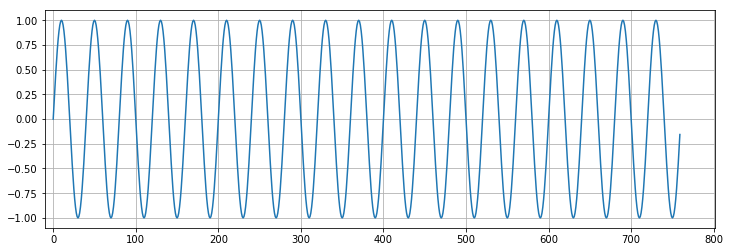

In [6]:
plt.figure(figsize= (12,4))
plt.xlim(-10, 801)
plt.grid(True)
plt.plot(train_set.numpy())
#we can see that we have separate off the very end

In [7]:
def input_data(seq, ws):
    
    out = [] #list of tuples a sequence and corresponding label
    L = len(seq)
    
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1] #+1 to predict one point into the future
        out.append((window,label))
    
    return out

In [8]:
window_size = 40

train_data = input_data(train_set, window_size)

In [9]:
len(train_data)

720

In [10]:
train_data[0]

(tensor([ 0.0000e+00,  1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,
          7.0711e-01,  8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
          1.0000e+00,  9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,
          7.0710e-01,  5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01,
         -7.2400e-06, -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01,
         -7.0711e-01, -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01,
         -1.0000e+00, -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01,
         -7.0710e-01, -5.8777e-01, -4.5398e-01, -3.0900e-01, -1.5642e-01]),
 tensor([1.4480e-05]))

In [11]:
train_data[1]

(tensor([ 1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,  7.0711e-01,
          8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,  1.0000e+00,
          9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,  7.0710e-01,
          5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01, -7.2400e-06,
         -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01, -7.0711e-01,
         -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01, -1.0000e+00,
         -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01, -7.0710e-01,
         -5.8777e-01, -4.5398e-01, -3.0900e-01, -1.5642e-01,  1.4480e-05]),
 tensor([0.1564]))

In [12]:
class LSTM(nn.Module):
    
    def __init__(self, input_size = 1, hidden_size = 50, out_size = 1):
        
        super().__init__()
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size, hidden_size)
        
        #condense back down to a single output
        self.linear = nn.Linear(hidden_size, out_size)
        
        #initial hidden states and cell states (H, C)
        self.hidden = (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size)) 

    def forward(self, seq):
        
        lstm_out , self.hidden = self.lstm(seq.view(len(seq), 1, -1), self.hidden)
        
        pred = self.linear(lstm_out.view(len(seq), -1))
        
        return pred[-1] #just show last value not entire sequence
        
        

In [13]:
torch.manual_seed(42)
model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr= 0.01)

In [14]:
model

LSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [15]:
for p in model.parameters():
    print(p.numel())

200
10000
200
200
50
1


Training and Forecasting

Epoch 0 Loss: 0.09212874621152878
Performance on test range: 0.6071590185165405


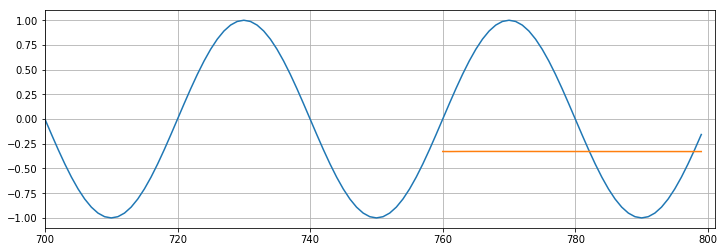

Epoch 1 Loss: 0.06506767123937607
Performance on test range: 0.565098762512207


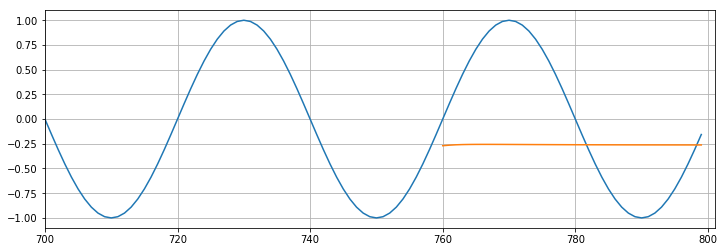

Epoch 2 Loss: 0.04198046773672104
Performance on test range: 0.5199716687202454


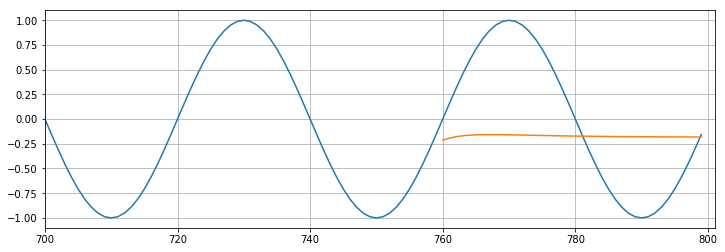

Epoch 3 Loss: 0.01784275658428669
Performance on test range: 0.42209967970848083


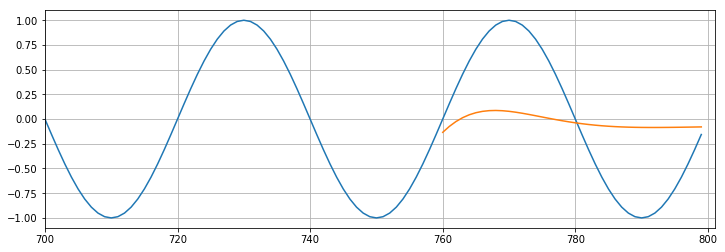

Epoch 4 Loss: 0.0028870997484773397
Performance on test range: 0.16624116897583008


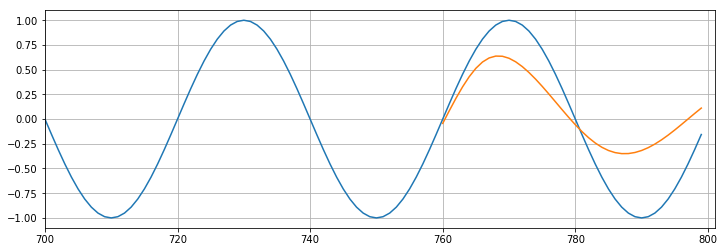

Epoch 5 Loss: 0.0003200757782906294
Performance on test range: 0.03055439703166485


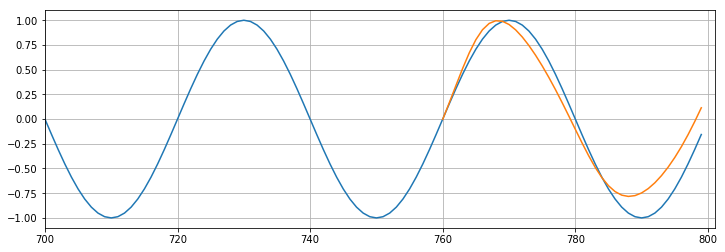

Epoch 6 Loss: 0.00012969104864168912
Performance on test range: 0.014990181662142277


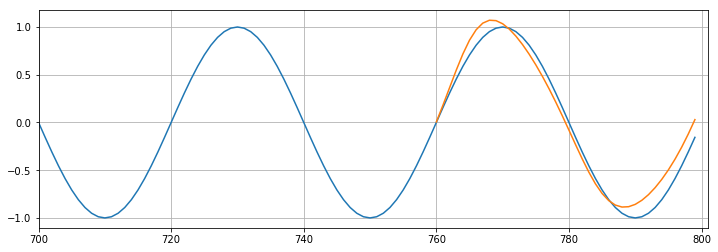

Epoch 7 Loss: 0.00012006733595626429
Performance on test range: 0.011856676079332829


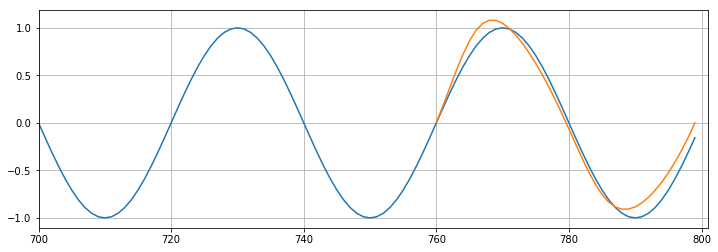

Epoch 8 Loss: 0.0001265565661014989
Performance on test range: 0.010163827799260616


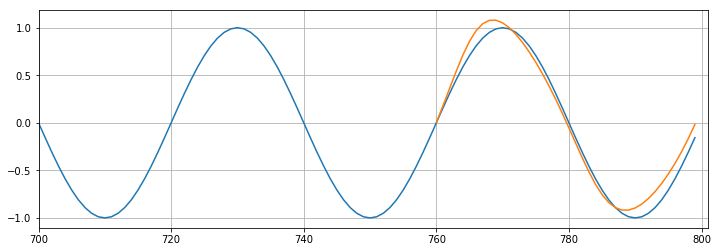

Epoch 9 Loss: 0.00013195407518651336
Performance on test range: 0.00889757089316845


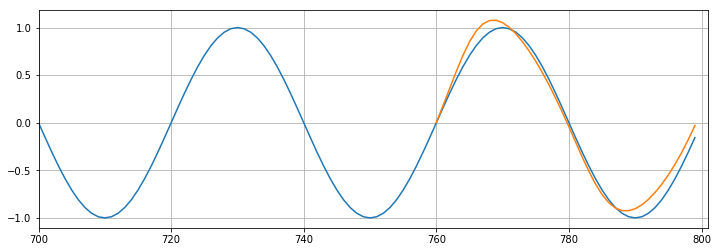

In [16]:
epochs = 10
future = 40

for i in range(epochs):
    
    for seq, y_train in train_data:
        
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1, 1, model.hidden_size),
                        torch.zeros(1, 1, model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {i} Loss: {loss.item()}")
    
    preds = train_set[-window_size:].tolist()
    
    for f in range(future):
        
        seq = torch.FloatTensor(preds[-window_size:])
        
        with torch.no_grad():
            
            model.hidden = (torch.zeros(1, 1, model.hidden_size),
                        torch.zeros(1, 1, model.hidden_size))
            
            preds.append(model(seq).item())
            
    loss = criterion(torch.tensor(preds[-window_size:]), y[760:])
    print(f'Performance on test range: {loss}')
    
    plt.figure(figsize = (12, 4))
    plt.xlim(700,801)
    plt.grid(True)
    plt.plot(y.numpy())
    plt.plot(range(760,800), preds[window_size:])
    plt.show()

In [17]:
epochs = 15
window_size = 40
future = 40

all_data = input_data(y, window_size)
len(all_data)

760

In [18]:
import time
start_time = time.time()

for i in range(epochs):
    
    for seq, y_train in train_data:
        
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1, 1, model.hidden_size),
                        torch.zeros(1, 1, model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {i} Loss: {loss.item()}")

total_time = time.time() - start_time
print(total_time/60)


Epoch 0 Loss: 0.0001345030323136598
Epoch 1 Loss: 0.0001345821947325021
Epoch 2 Loss: 0.00013279209088068455
Epoch 3 Loss: 0.0001296662667300552
Epoch 4 Loss: 0.00012561386392917484
Epoch 5 Loss: 0.00012097590661142021
Epoch 6 Loss: 0.00011599756544455886
Epoch 7 Loss: 0.0001108607102651149
Epoch 8 Loss: 0.00010570746962912381
Epoch 9 Loss: 0.0001006296297418885
Epoch 10 Loss: 9.569484245730564e-05
Epoch 11 Loss: 9.094662527786568e-05
Epoch 12 Loss: 8.641312160762027e-05
Epoch 13 Loss: 8.210809028241783e-05
Epoch 14 Loss: 7.803594780853018e-05
6.89758491118749


forcast into unknown future

In [19]:
pred = y[-window_size:].tolist()

for i in range(future):
    
    seq = torch.FloatTensor(preds[-window_size:])
    
    model.hidden = (torch.zeros(1, 1, model.hidden_size),
                        torch.zeros(1, 1, model.hidden_size))
    
    pred.append(model(seq).item())

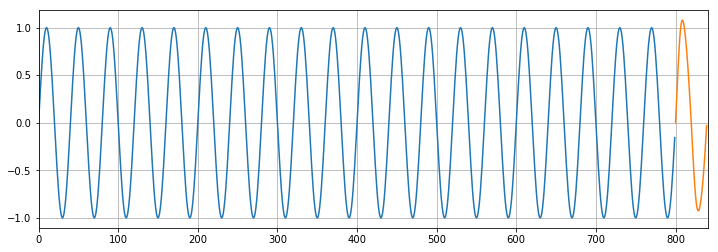

In [20]:
plt.figure(figsize = (12,4))
plt.xlim(0, 841)
plt.grid(True)
plt.plot(y.numpy())
#plotting the forecast
plt.plot(range(800, 800+future), preds[window_size:])

RNN on a Time Series

In [21]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# This relates to plotting datetime values with matplotlib:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [22]:
df = pd.read_csv('../Data/TimeSeriesData/Alcohol_Sales.csv', index_col = 0, parse_dates = True)

In [23]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [24]:
len(df)

325

In [25]:
#drop any null values
df = df.dropna() 

In [27]:
len(df)
#length is the same so there were none

325

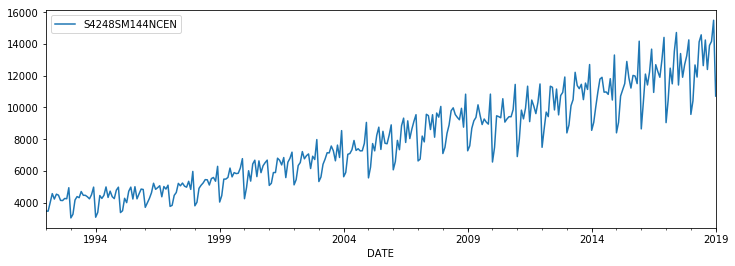

In [30]:
df.plot(figsize = (12, 4))

we can see some clear seasonality and an upward trend

In [32]:
#need numbers to be floats not strings
y = df['S4248SM144NCEN'].values.astype(float)

In [33]:
test_size = 12

In [34]:
train_set = y[:-test_size]
test_set = y[-test_size:]

In [36]:
test_set
#the last year worth of values

array([10415., 12683., 11919., 14138., 14583., 12640., 14257., 12396.,
       13914., 14174., 15504., 10718.])

RNN will often perform better if weights and biases are normalized

In [37]:
from sklearn.preprocessing import MinMaxScaler

In [38]:
scaler = MinMaxScaler(feature_range = (-1, 1))

Only want to scale based on min and max of training set so we dont "leak" the max value of the test set

In [39]:
scaler.fit(train_set.reshape(-1, 1))

MinMaxScaler(copy=True, feature_range=(-1, 1))

In [40]:
train_norm = scaler.transform(train_set.reshape(-1, 1))

In [41]:
train_norm = torch.FloatTensor(train_norm).view(-1)

In [42]:
#train_norm

tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
        -0.8128, -0.7901, -0.7933, -0.6743, -1.0000, -0.9607, -0.8070, -0.7699,
        -0.7819, -0.7154, -0.7560, -0.7562, -0.7721, -0.7940, -0.7489, -0.6678,
        -0.9925, -0.9408, -0.7586, -0.7897, -0.7557, -0.6660, -0.7790, -0.7114,
        -0.7704, -0.7919, -0.7003, -0.6683, -0.9420, -0.9226, -0.7884, -0.8354,
        -0.7121, -0.6678, -0.7962, -0.6634, -0.7942, -0.7396, -0.6889, -0.6931,
        -0.8858, -0.8373, -0.7896, -0.7285, -0.6260, -0.6914, -0.6735, -0.6528,
        -0.7719, -0.6613, -0.6890, -0.6468, -0.8757, -0.8643, -0.7567, -0.7258,
        -0.6275, -0.6536, -0.6239, -0.6576, -0.6685, -0.6049, -0.6923, -0.4984,
        -0.8692, -0.8311, -0.6808, -0.6480, -0.6229, -0.5870, -0.5890, -0.6451,
        -0.5753, -0.5637, -0.6042, -0.4435, -0.8289, -0.7600, -0.5815, -0.5808,
        -0.5630, -0.4623, -0.5572, -0.5114, -0.5218, -0.5182, -0.4617, -0.3606,
        -0.7928, -0.6716, -0.4911, -0.60

In [43]:
# a good wndow size takes up a whole season
# in this case a month
window_size = 12

In [50]:
def input_data(seq,ws):  # ws is the window size
    
    out = []
    L = len(seq)
    
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out


In [51]:
train_data = input_data(train_norm,window_size)

In [52]:
len(train_data)

301

In [53]:
#325-12-12

In [54]:
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))

In [55]:
class LSTMnetwork(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 100, output_size = 1): 
        #hidden size 100 becuase its a more complex data set
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size, hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size, output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1, 1, self.hidden_size),
                       torch.zeros(1, 1, self.hidden_size))

    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq), 1, -1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq), -1))
        return pred[-1]  # we only want the last value

In [56]:
torch.manual_seed(101)

model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [57]:
model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [58]:
epochs = 100

import time
start_time = time.time()

for epoch in range(epochs):
    
    for seq, y_train in train_data:
        
        optimizer.zero_grad()
        
        model.hidden = (torch.zeros(1, 1, model.hidden_size),
                        torch.zeros(1, 1, model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    print(f'Epoch {epoch} Loss {loss.item()}')


total_time = time.time() - start_time
print(total_time/60)

Epoch 0 Loss 0.25314345955848694
Epoch 1 Loss 0.37523898482322693
Epoch 2 Loss 0.3901209831237793
Epoch 3 Loss 0.349496990442276
Epoch 4 Loss 0.3307788074016571
Epoch 5 Loss 0.3323073089122772
Epoch 6 Loss 0.3266769051551819
Epoch 7 Loss 0.32077038288116455
Epoch 8 Loss 0.3065176010131836
Epoch 9 Loss 0.2951700687408447
Epoch 10 Loss 0.26913928985595703
Epoch 11 Loss 0.25979408621788025
Epoch 12 Loss 0.2459997683763504
Epoch 13 Loss 0.2222774624824524
Epoch 14 Loss 0.18593749403953552
Epoch 15 Loss 0.18445566296577454
Epoch 16 Loss 0.17432530224323273
Epoch 17 Loss 0.2582225203514099
Epoch 18 Loss 0.2242051064968109
Epoch 19 Loss 0.23121914267539978
Epoch 20 Loss 0.19758883118629456
Epoch 21 Loss 0.18989050388336182
Epoch 22 Loss 0.2104491889476776
Epoch 23 Loss 0.16945958137512207
Epoch 24 Loss 0.14590860903263092
Epoch 25 Loss 0.11834970861673355
Epoch 26 Loss 0.0001621616684133187
Epoch 27 Loss 0.0064497096464037895
Epoch 28 Loss 0.050497524440288544
Epoch 29 Loss 0.0127326799556612

In [59]:
future = 12

preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    
    seq = torch.FloatTensor(preds[-window_size:])
    
    with torch.no_grad():
        
        model.hidden = (torch.zeros(1, 1, model.hidden_size),
                        torch.zeros(1, 1, model.hidden_size))
        
        preds.append(model(seq).item())

In [60]:
preds[window_size:]
#normalized values that are predicted into the test set

[0.21764472126960754,
 0.7362536787986755,
 0.42575034499168396,
 0.8574904799461365,
 1.24961256980896,
 0.32853081822395325,
 0.8707497715950012,
 0.6814860105514526,
 0.601524293422699,
 0.9176154732704163,
 0.8960760235786438,
 0.18404555320739746]

In [63]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))

In [64]:
true_predictions

array([[10153.61279707],
       [13187.21589413],
       [11370.92664303],
       [13896.39056244],
       [16190.1087271 ],
       [10802.2410212 ],
       [13973.95078894],
       [12866.85241872],
       [12399.11635438],
       [14248.0917109 ],
       [14122.09669992],
       [ 9957.07446349]])

In [65]:
#have to add in date time stamps so we can plot
x = np.arange('2018-02-01', '2019-02-01', dtype = 'datetime64[M]') 
#one time stamp beyond what you want

In [66]:
x

array(['2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07',
       '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01'],
      dtype='datetime64[M]')

In [67]:
df.index

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
               '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
               '2018-12-01', '2019-01-01'],
              dtype='datetime64[ns]', name='DATE', length=325, freq=None)

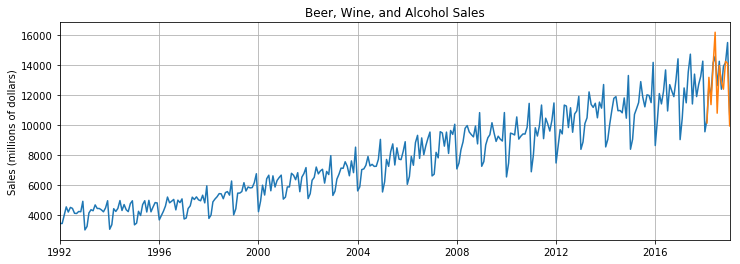

In [68]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN']) #plot original
plt.plot(x,true_predictions) #plot true predictions
plt.show()

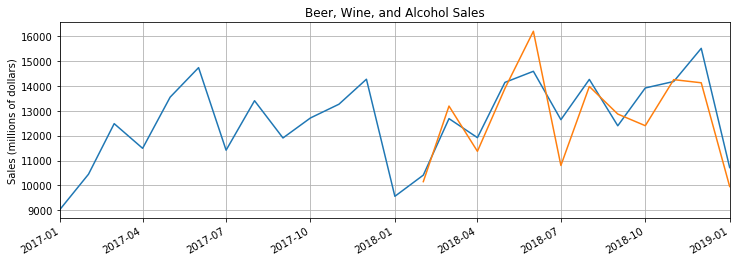

In [69]:
#zoom into the end of the graph to see the comparison better
# Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()

forecast into the unknown future

In [70]:
epochs = 100

# set model to back to training mode
model.train()

# feature scale the entire dataset
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm, window_size)

import time
start_time = time.time()

for epoch in range(epochs):
    
    # train on the full set of sequences
    for seq, y_train in all_data:  
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1, 1, model.hidden_size),
                        torch.zeros(1, 1, model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.01454567
Epoch:  2 Loss: 0.01350383
Epoch:  3 Loss: 0.02643331
Epoch:  4 Loss: 0.01324219
Epoch:  5 Loss: 0.01439027
Epoch:  6 Loss: 0.01231953
Epoch:  7 Loss: 0.01169418
Epoch:  8 Loss: 0.01061528
Epoch:  9 Loss: 0.00724249
Epoch: 10 Loss: 0.00424754
Epoch: 11 Loss: 0.00208558
Epoch: 12 Loss: 0.00440567
Epoch: 13 Loss: 0.01001350
Epoch: 14 Loss: 0.00601961
Epoch: 15 Loss: 0.00487102
Epoch: 16 Loss: 0.00251737
Epoch: 17 Loss: 0.00400521
Epoch: 18 Loss: 0.00497501
Epoch: 19 Loss: 0.00461044
Epoch: 20 Loss: 0.00193556
Epoch: 21 Loss: 0.00038231
Epoch: 22 Loss: 0.00528781
Epoch: 23 Loss: 0.00042755
Epoch: 24 Loss: 0.00195656
Epoch: 25 Loss: 0.00191549
Epoch: 26 Loss: 0.00084451
Epoch: 27 Loss: 0.00021586
Epoch: 28 Loss: 0.00923860
Epoch: 29 Loss: 0.00273661
Epoch: 30 Loss: 0.00330967
Epoch: 31 Loss: 0.00159039
Epoch: 32 Loss: 0.00249826
Epoch: 33 Loss: 0.00335327
Epoch: 34 Loss: 0.00662615
Epoch: 35 Loss: 0.00236142
Epoch: 36 Loss: 0.00001399
Epoch: 37 Loss: 0.00416735
E

In [71]:
window_size = 12
future = 12
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    
    seq = torch.FloatTensor(preds[-window_size:])
    
    with torch.no_grad():
        
        model.hidden = (torch.zeros(1, 1, model.hidden_size),
                        torch.zeros(1, 1, model.hidden_size))
        
        preds.append(model(seq).item())
        

In [74]:
#true meaning not normalized
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

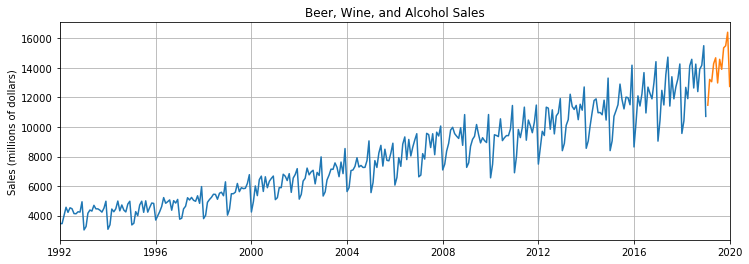

In [75]:
x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions[window_size:])
plt.show()

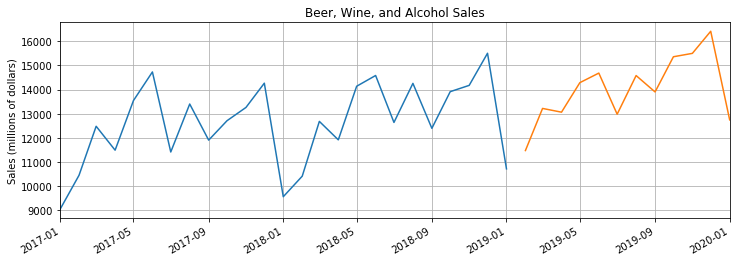

In [76]:
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions[window_size:])
plt.show()

Below is just a more consise way to take in a time series training data set and output a tensor of (sequence, label) tuples 

In [77]:
# Load dependencies
from sklearn.preprocessing import MinMaxScaler

# Instantiate a scaler
"""
This has to be done outside the function definition so that
we can inverse_transform the prediction set later on.
"""
scaler = MinMaxScaler(feature_range=(-1, 1))

# Extract values from the source .csv file
df = pd.read_csv('../Data/TimeSeriesData/Alcohol_Sales.csv',index_col=0,parse_dates=True)
y = df['S4248SM144NCEN'].values.astype(float)

# Define a test size
test_size = 12

# Create the training set of values
train_set = y[:-test_size]

In [78]:
# DEFINE A FUNCTION:
def create_train_data(seq,ws=12):
    """Takes in a training sequence and window size (ws) of
       default size 12, returns a tensor of (seq/label) tuples"""
    seq_norm = scaler.fit_transform(seq.reshape(-1, 1))    
    seq_norm = torch.FloatTensor(seq_norm).view(-1)

    out = []
    L = len(seq_norm)
    for i in range(L-ws):
        window = seq_norm[i:i+ws]
        label = seq_norm[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [79]:
# Apply the function to train_set
train_data = create_train_data(train_set,12)
len(train_data)  # this should equal 313-12

301

In [80]:
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))

In [81]:
help(create_train_data)

Help on function create_train_data in module __main__:

create_train_data(seq, ws=12)
    Takes in a training sequence and window size (ws) of
    default size 12, returns a tensor of (seq/label) tuples

